<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 15


In [1]:
import sys
sys.path.append("../")

In [2]:
from itertools import cycle, islice
import numpy as np

In [3]:
from sklearn import mixture
from sklearn import metrics
from pomegranate import *

In [4]:
from scipy.stats import kde
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [5]:
from helpers import read_configuration_file, INFO, WARNING
from train import main
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [6]:
sns.set(color_codes=True)

In [7]:
def load_data_file(filename):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        region_means = [float(item) for item in arraystr]
        return region_means

In [8]:
# change here accordingly the paths


wga_mean_tuf_I_file = "/home/david/Desktop/wga_windows_mean_0_TUF_DETAIL_I.txt"
no_wga_mean_tuf_I_file = "/home/david/Desktop/no_wga_windows_mean_0_TUF_DETAIL_I.txt"
#gc_tuf_I_file = "/home/david/Desktop/windows_gc_0_TUF_DETAIL_I.txt"

#wga_mean_tuf_II_file = "/home/a/ag568/wga_windows_mean_0_TUF_DETAIL_II.txt"
#no_wga_mean_tuf_II_file = "/home/a/ag568/no_wga_windows_mean_0_TUF_DETAIL_II.txt"
#gc_tuf_II_file = "/home/a/ag568/windows_gc_0_TUF_DETAIL_II.txt"

wga_mean_single_copy_deletion_file = "/home/david/Desktop/wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
no_wga_mean_single_copy_deletion_file = "/home/david/Desktop/no_wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
#gc_single_copy_deletion_file = "/home/david/Desktop/windows_gc_0_SINGLE_COPY_DELETION.txt"

wga_mean_duplication_file = "/home/david/Desktop/wga_windows_mean_0_DUPLICATION.txt"
no_wga_mean_duplication_file = "/home/david/Desktop/no_wga_windows_mean_0_DUPLICATION.txt"
#gc_duplication_file = "/home/david/Desktop/windows_gc_0_DUPLICATION.txt"

wga_mean_delete_file = "/home/david/Desktop/wga_windows_mean_0_DELETE.txt"
no_wga_mean_delete_file = "/home/david/Desktop/no_wga_windows_mean_0_DELETE.txt"
#gc_delete_file = "/home/david/Desktop/windows_gc_0_DELETE.txt"

In [9]:
wga_mu_tuf_I = load_data_file(filename=wga_mean_tuf_I_file)
no_wga_mu_tuf_I = load_data_file(filename=no_wga_mean_tuf_I_file)
#gc_tuf_I = load_data_file(filename=gc_tuf_I_file)

In [10]:
wga_mu_single_copy_deletion = load_data_file(filename=wga_mean_single_copy_deletion_file)
no_wga_mu_single_copy_deletion = load_data_file(filename=no_wga_mean_single_copy_deletion_file)
#gc_single_copy_deletion = load_data_file(filename=gc_single_copy_deletion_file)

In [13]:
wga_mu_duplication = load_data_file(filename=wga_mean_duplication_file)
no_wga_mu_duplication = load_data_file(filename=no_wga_mean_duplication_file)
#gc_duplication = load_data_file(filename=gc_duplication_file)

In [14]:
wga_mu_delete = load_data_file(filename=wga_mean_delete_file)
no_wga_mu_delete = load_data_file(filename=no_wga_mean_delete_file)
#gc_delete = load_data_file(filename=gc_delete_file)

In [15]:
# mix the data

# WGA sample
wga_mu = []
wga_mu.extend(wga_mu_tuf_I)
#wga_mu.extend(wga_mu_tuf_II)
wga_mu.extend(wga_mu_single_copy_deletion)
wga_mu.extend(wga_mu_duplication)
wga_mu.extend(wga_mu_delete)


# NO-WGA sample
no_wga_mu = []
no_wga_mu.extend(no_wga_mu_tuf_I)
#no_wga_mu.extend(no_wga_mu_tuf_II)
no_wga_mu.extend(no_wga_mu_single_copy_deletion)
no_wga_mu.extend(no_wga_mu_duplication)
no_wga_mu.extend(no_wga_mu_delete)


# GC
#gc = []
#gc.extend(gc_tuf_I)
#gc.extend(gc_tuf_II)
#gc.extend(gc_single_copy_deletion)
#gc.extend(gc_duplication)
#gc.extend(gc_delete)

In [16]:
def make_data_array(wga_mu, no_wga_mu, gc, use_ratio, use_gc):
    data = []
    
    if use_ratio and use_gc:
        for no_wga_val, wga_val,gc_val in zip(no_wga_mu, wga_mu, gc):
            data.append([no_wga_val, wga_val, (wga_val + 1)/(no_wga_val + 1), gc_val])
    elif use_ratio:
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga,  (wga + 1)/(no_wga + 1)])
    elif use_gc:
        
        for no_wga_val, wga_val , gc_val in zip(no_wga_mu, wga_mu,  gc):
            data.append([no_wga_val, wga_val, gc_val])
    else:
        
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga ])
        
    return data

In [17]:
def gmm_clustering(clusters, data, cov_type, tol, max_itrs, 
                   n_init, no_wga_mu, wga_mu, xlim, ylim, nbins=80 ):
    
    #for nclusters in clusters:
    
        print("Number of clusters ", clusters)
        gmm = mixture.GaussianMixture(n_components=clusters,
                                      covariance_type=cov_type,
                                      tol=tol, max_iter=max_itrs,
                                      n_init=n_init)
        gmm.fit(data)
        print("Converged: ", gmm.converged_)
        print("BIC: ", gmm.bic(data))
        labels = gmm.predict(data)
        
        print("Len of labels: ", len(labels))

        #colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
        #                                     '#f781bf', '#a65628', '#984ea3',
        #                                     '#999999', '#e41a1c', '#dede00']),
        #                                  int(max(labels) + 1))))
        
        #colors = np.array(['#377eb8', '#ff7f00', '#4daf4a',
        #                    '#f781bf', '#a65628'])
        
        colors = np.array(['green', 'blue', 'red', 'yellow', 'pink'])

        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        colors = colors[labels]
       
        

        plt.scatter(no_wga_mu, wga_mu,  color=colors)
        
        kernel= kde.gaussian_kde(np.vstack([no_wga_mu, wga_mu]))
        xi, yi = np.mgrid[min(no_wga_mu):max(no_wga_mu):nbins*1j, 
                          min(wga_mu):max(wga_mu):nbins*1j]
        
        zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        #plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='Blues')
        plt.contour(xi, yi, zi.reshape(xi.shape), 24 )
        
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()
        
        # map that holds the association between the
        # component color and component index
        
        color_comp_assoc = {}
        for label, color in zip(labels, colors):
            if color in color_comp_assoc.keys():
                assert color_comp_assoc[color] == label
            else:
                color_comp_assoc[color] = label
        
        return gmm, labels, color_comp_assoc

## Cluster the reference data

In [18]:
# Dictionay that holds the states for the HMM 
states={}

In [19]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

Number of clusters  5
Converged:  True
BIC:  174638.80356616594
Len of labels:  12972


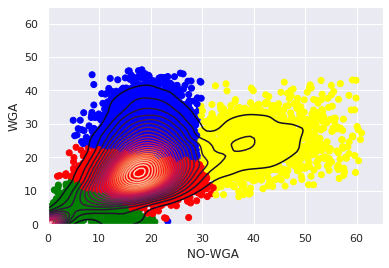

In [20]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=5, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 65.0),
                                                 ylim=(0., 65.0))

In [21]:
print("Color-cluster association", color_comp_assoc)


Color-cluster association {'blue': 1, 'red': 2, 'green': 0, 'pink': 4, 'yellow': 3}


In [25]:
means = gmm.means_
print("Means: ", means)
weights = gmm.weights_
#print("Weights: ", weights)
covariances = gmm.covariances_
print("Covariances: ", covariances)

Means:  [[ 8.66113875  5.67688704]
 [19.47238698 24.12008857]
 [17.75181185 14.82806864]
 [39.14502478 24.17610895]
 [ 0.13156743  0.14825348]]
Covariances:  [[2.47395417e+01 1.27773706e+01]
 [2.01712519e+01 5.41376920e+01]
 [2.28801885e+01 1.67969997e+01]
 [7.60266265e+01 3.96431832e+01]
 [5.79641267e-02 7.28652865e-02]]


This depends on the clustering above so we need to make sure that colors do align

In [26]:
states_map = {"Duplication": 3, "Normal-I": 2, "Normal-II":1, 
              "Deletion": 4, "Single-Deletion": 0}

In [28]:


for state in states_map:
    name = state
    idx = states_map[state]
    
    # change the order of the means to match the order of the
    # data we will retrieve below in the prediction step
    mu_no_wga = means[idx][0]
    mu_wga = means[idx][1]
    mu = np.array([mu_wga, mu_no_wga])
    cov = covariances[idx]
    cov = np.array([[cov[1], 0.0], [0.0, cov[0]]])

    states[name]  = State(MultivariateGaussianDistribution(means=mu,
                                                       covariance=cov), name=name)


### Cluster for TUF

Simply use the ref TUF I region to extract the distribution.

In [29]:
tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf_I)

tuf_no_wga_mu = []
tuf_no_wga_mu.extend(no_wga_mu_tuf_I)

In [30]:
data = make_data_array(wga_mu=tuf_wga_mu, 
                       no_wga_mu=tuf_no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

data = np.array(data)

assert data.shape == (len(tuf_wga_mu), 3)

Number of clusters  3
Converged:  True
BIC:  15265.07490392829
Len of labels:  1231


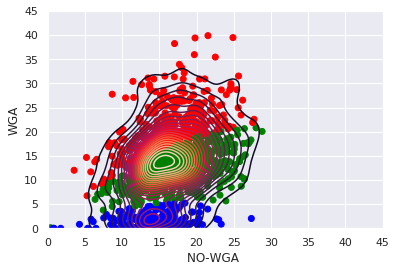

In [31]:
gmm_tuf, labels_tuf, color_comp_assoc_tuf = gmm_clustering(clusters=3, data=data, tol=1.0e-5, cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=tuf_no_wga_mu, 
                                                 wga_mu=tuf_wga_mu,
                                                 xlim=(0., 45.0),
                                                 ylim=(0., 45.0))

In [32]:
print("Color-cluster association for TUF", color_comp_assoc_tuf)

Color-cluster association for TUF {'red': 2, 'green': 0, 'blue': 1}


In [33]:
tuf_idx = 1

In [34]:

mu_no_wga = means[tuf_idx][0]
mu_wga = means[tuf_idx][1]
mu = np.array([mu_wga, mu_no_wga])
cov = covariances[tuf_idx]
cov = np.array([[cov[1], 0.0], [0.0, cov[0]]])
name = "TUF"
states[name]  = State(MultivariateGaussianDistribution(means=mu,
                                                       covariance=cov), name=name)

## Apply HMM

In [35]:
# load the configuration
configuration = read_configuration_file("../config.json")

In [36]:
hmm_config = configuration["HMM"]

In [37]:
hmm_states = hmm_config["states"]

In [38]:
hmm_transitions =  hmm_config["transitions"]

### Train HMM

In [39]:
gap_state = None
gap_state_dist = None


In [40]:
if configuration["remove_windows_with_gaps"] == False:
    
    name="GAP_STATE"
    
    # we have a gap state then add it
    gap_windows_dist = configuration["gap_windows_dist"]
    gap_state_dist = get_dist_list(dists_name=[gap_windows_dist["name"],
                                               gap_windows_dist["name"]],
                                               params={"uniform_params":gap_windows_dist["config"]["parameters"]})

    gap_state = \
            State(IndependentComponentsDistribution(gap_state_dist), 
                  name=name)
    states[name] = gap_state

In [41]:
print("{0} Number of states: {1}".format(INFO, len(states)))
for state in states:
    print(state)

INFO: Number of states: 7
Duplication
Normal-I
Normal-II
Deletion
Single-Deletion
TUF
GAP_STATE


In [42]:
# print info about the states
for name in states:
    state = states[name]
    print("{0} State: {1}".format(INFO, state.name))
    state_map = json.loads(str(state))
    print("{0} Distributions: {1}".format(INFO,
                                          state_map["distribution"]))

# create the HMM
hmm_model = HiddenMarkovModel(name=hmm_config["name"],
                              start=None, end=None)

states_list = []
for state in states:
    states_list.append(states[state])
hmm_model.add_states(states_list)

INFO: State: Duplication
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[24.1761089528738, 39.14502477511704], [[39.64318322538884, 0.0], [0.0, 76.02662645698285]]], 'frozen': False}
INFO: State: Normal-I
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[14.828068642751404, 17.751811854699863], [[16.796999664116615, 0.0], [0.0, 22.880188530313607]]], 'frozen': False}
INFO: State: Normal-II
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[24.120088569400593, 19.47238697609908], [[54.137691996599756, 0.0], [0.0, 20.171251921846423]]], 'frozen': False}
INFO: State: Deletion
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[0.14825347597716207, 0.13156743314710448], [[0.07286528646475866, 0.0], [0.0, 0.057964126678959366]]], 'frozen': False}
INFO: State: Single-D

In [43]:
start_prob = 1.0/len(states)
hmm_config["states"]={}

for state in states:
    hmm_config["states"][state] = {"start_prob":start_prob}

In [44]:
print("Startring probabilities....")
for state in states:
    print("State: {0}, probability: {1} ".format(state,hmm_config["states"][state]["start_prob"]))
    

Startring probabilities....
State: Duplication, probability: 0.14285714285714285 
State: Normal-I, probability: 0.14285714285714285 
State: Normal-II, probability: 0.14285714285714285 
State: Deletion, probability: 0.14285714285714285 
State: Single-Deletion, probability: 0.14285714285714285 
State: TUF, probability: 0.14285714285714285 
State: GAP_STATE, probability: 0.14285714285714285 


Form the transition probabilities

In [45]:
self_trans = 0.95
off_trans = 0.016
hmm_config["transitions"]={}

for state_i in states:
    for state_j in states:
        state_name = state_i + "-" + state_j
        if state_i == state_j:
            hmm_config["transitions"][state_name] = self_trans
        else:
            hmm_config["transitions"][state_name] = off_trans

In [46]:
for state in states:
    prob = hmm_config["states"][state]["start_prob"]
    hmm_model.add_transition(hmm_model.start, states[state], prob)

# add transitions for every state
# to another this will create a dense HMM
for state_i in states:
    for state_j in states:
        if state_i + "-" + state_j in hmm_config["transitions"]:
                prob =hmm_config["transitions"][state_i + "-" + state_j]
                hmm_model.add_transition(states[state_i], states[state_j], prob)
        else:
                print("{0} Transition from state"
              " {1} to state {2} is not specified".format(WARNING,
                                                          state_i,
                                                          state_j))



In [47]:
# finally we need to bake
hmm_model.bake(verbose=True)

HMM_Model : Duplication summed to 1.046, normalized to 1.0
HMM_Model : Normal-I summed to 1.046, normalized to 1.0
HMM_Model : Normal-II summed to 1.046, normalized to 1.0
HMM_Model : Deletion summed to 1.046, normalized to 1.0
HMM_Model : Single-Deletion summed to 1.046, normalized to 1.0
HMM_Model : TUF summed to 1.046, normalized to 1.0
HMM_Model : GAP_STATE summed to 1.046, normalized to 1.0


## HMM Predict

In [48]:
#%debug 
# load the region we want to use for prediction
region_file = "/home/david/Desktop/region_0_GMM.txt"
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

INFO: Loading region from file: /home/david/Desktop/region_0_GMM.txt


In [49]:
# visualize the model we just trained
#plt.figure( figsize=(20,18) )
#hmm.plot()
#plt.show()

In [50]:
# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

Sequence length:  186767


In [51]:
observations = []
for i in range(len(sequence)):
    observations.append(sequence[i][0])

print("Observation length: ", len(observations))

time_start = time.perf_counter()
viterbi_path = hmm_model.viterbi(observations)
time_end = time.perf_counter()
print("Done. Execution time"
          " {0} secs".format(time_end - time_start))
print("Log-probability of ML Viterbi path: ", viterbi_path[0])


if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))

        filename="viterbi_path.txt"
        counter = 0
        with open(filename, 'w') as f:
            f.write(str(len(viterbi_path[1])-1) + "\n")
            for item in range(len(sequence)):

                if sequence[item][0] == (-999.0, -999.0):
                    counter += 1

                f.write(str(item)+ ":" + str(sequence[item][1]) + ":" + str(sequence[item][0]) + ":" + viterbi_path[1][item+1][1].name + "\n")
                #print("sequnce item: {0} state {1}".format(sequence[item], viterbi_path[1][item+1][1].name))
        print("There should be {0} gaps".format(counter))
else:
        print("Viterbi path is impossible for the given sequence")

Observation length:  186767
Done. Execution time 0.717581108000104 secs
Log-probability of ML Viterbi path:  -1168609.5367285467
Viterbi path length:  186768
There should be 1438 gaps
